In [11]:
## ==========================
# 1. Librerías necesarias
# ==========================
!pip install opencv-python pillow matplotlib

import cv2
import numpy as np
import tensorflow as tf
from PIL import Image, ImageOps
import matplotlib.pyplot as plt


In [12]:

# ==========================
# 2. Cargar modelo TFLite desde Drive
# ==========================
tflite_model_path = "/content/drive/MyDrive/Taller Integrador/Modelo/model.tflite"
labels_path = "/content/drive/MyDrive/Taller Integrador/Modelo/labels_tflite.txt"

# Intérprete TFLite
interpreter = tf.lite.Interpreter(model_path=tflite_model_path)
interpreter.allocate_tensors()

# Detalles de entrada/salida
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Etiquetas
class_names = open(labels_path, "r").readlines()

print("✅ Modelo TFLite cargado correctamente")


✅ Modelo TFLite cargado correctamente


In [13]:

# ==========================
# 3. Función de preprocesamiento
# ==========================
def preprocess_image(img):
    size = (224, 224)  # Teachable usa 224x224
    img = ImageOps.fit(Image.fromarray(img), size, Image.Resampling.LANCZOS)
    img_array = np.asarray(img).astype(np.float32)
    normalized = (img_array / 127.5) - 1  # Normalización [-1,1]
    return np.expand_dims(normalized, axis=0)


In [14]:

# ==========================
# 4. Función para detectar insectos y contar
# ==========================
def detectar_insectos(image_path, min_area=50, conf_thresh=0.7):
    img = cv2.imread(image_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Binarización para resaltar manchas
    _, thresh = cv2.threshold(gray, 180, 255, cv2.THRESH_BINARY_INV)

    # Encontrar contornos
    contornos, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    conteo = 0

    for c in contornos:
        if cv2.contourArea(c) > min_area:
            x, y, w, h = cv2.boundingRect(c)
            roi = img[y:y+h, x:x+w]

            # Preprocesar ROI
            data = preprocess_image(roi)

            # Pasar al modelo TFLite
            interpreter.set_tensor(input_details[0]['index'], data)
            interpreter.invoke()
            prediction = interpreter.get_tensor(output_details[0]['index'])

            index = np.argmax(prediction)
            class_name = class_names[index].strip()
            confidence = prediction[0][index]

            if "insecto" in class_name.lower() and confidence > conf_thresh:
                conteo += 1
                cv2.rectangle(img, (x,y), (x+w, y+h), (0,255,0), 2)
                cv2.putText(img, f"{class_name} {confidence:.2f}",
                            (x, y-5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,255,0), 1)

    print(f"🔢 Total de insectos detectados: {conteo}")

    # Mostrar resultado
    plt.figure(figsize=(10,8))
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.show()

    return conteo


🔢 Total de insectos detectados: 1


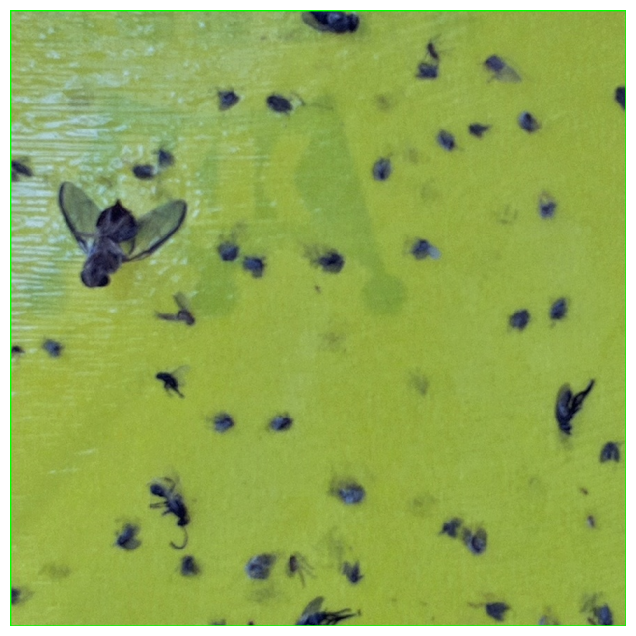

In [16]:

# ==========================
# 5. Probar con una imagen
# ==========================
conteo = detectar_insectos("/content/drive/MyDrive/Taller Integrador/Prueba/ejemplo_01.jpg")